# Details

Assignment
- [20 marks] <b>Custom Loss function Design and evaluation:</b> Extension of cross entropy loss to add penalty for all classes, not just the true class. Think of how you will give penalty, when you will give penalty, what will you do if some false class is predicted with very low probability
- [20 marks] <b>Regularization Loss:</b> Add a regularizer that promotes orthogonal filters at each layer
- [20 marks] <b>Explore Focal Loss and SMOTE</b> and other techniques to handle class imbalance in the dataset
- [20 marks] <b>Neural Architecture Search:</b> Since the input is only 28x28 and there are 62 classes, we can work with a smaller network. Our goal is to beat the performance [Accuracy, Precision, Recall, F1 Score] of ResNet with much smaller number of parameters. Report both micro-average and macro-average performance.
- [20 marks] Write a report with insights obtained and well-documented code. 

Components done so far:
1. sample classifier class
2. added regularizer component
3. sample network class
4. dataset downloaded
5. orthogonal regularizer added
6. custom loss function added
7. focal loss added
8. smote added
9. borderline smote added
10. ResNet model added


# Codebase

In [1]:
!pip install imbalanced-learn

## Main Class

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class ImageClassifier:
    def __init__(self, network, optimizer, criterion, l2_lambda=0.01):
        self.network = network
        self.optimizer = optimizer
        self.criterion = criterion
        self.l2_lambda = l2_lambda
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.network.to(self.device)
    
    def _regularize(self, network, l2_lambda):
        # Compute L2 regularization
        l2_reg = 0.0
        for param in network.parameters():
            l2_reg += torch.norm(param, 2)
        
        return l2_lambda * l2_reg
            
    def compute_loss(self, outputs, targets, l2_lambda=0.01):
        # Compute the cross-entropy loss
        ce_loss = self.criterion(outputs, targets)
        
        # Compute regularization loss
        l2_reg = self._regularize(self.network, l2_lambda)
        
        return ce_loss + l2_reg
    
    def train(self, train_loader, val_loader, n_epochs=10, patience=3):
        best_val_loss = float('inf')
        current_patience = 0
        
        for epoch in range(n_epochs):
            # Train
            self.network.train()
            train_loss = 0.0
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                
                # Forward pass
                outputs = self.network(data)
                
                # Compute loss
                loss = self.compute_loss(outputs, target)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
            
            # Validate
            self.network.eval()
            val_loss = 0.0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    
                    # Forward pass
                    outputs = self.network(data)
                    
                    # Compute loss
                    loss = self.compute_loss(outputs, target)
                    val_loss += loss.item()
            
            # Print epoch statistics
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            
            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                current_patience = 0
            else:
                current_patience += 1
                if current_patience >= patience:
                    print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
                    break
    
    def test(self, test_loader):
        self.network.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                # Forward pass
                outputs = self.network(data)
                
                # Compute loss
                loss = self.compute_loss(outputs, target)
                test_loss += loss.item()
                
                # Compute accuracy
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

## Dummy Dataset and Architecture

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Dummy dataset class (for demonstration)
class DummyDataset(Dataset):
    def __init__(self, size=1000, transform=None):
        self.data = torch.randn(size, 3, 32, 32)  # Dummy data: 1000 RGB images of size 32x32
        self.targets = torch.randint(0, 10, (size,))  # Dummy targets: 1000 classes (0-9)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

# Create dummy datasets and loaders
train_dataset = DummyDataset(size=800)
val_dataset = DummyDataset(size=200)
test_dataset = DummyDataset(size=500)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Example neural network architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 10)  # Assuming 10 classes for classification
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the neural network, optimizer, and criterion
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create an instance of ImageClassifier
classifier = ImageClassifier(model, optimizer, criterion)

# Train the classifier
classifier.train(train_loader, val_loader, n_epochs=10, patience=3)

# Test the classifier
classifier.test(test_loader)

Epoch 1/10, Train Loss: 2.6685, Val Loss: 2.5591
Epoch 2/10, Train Loss: 2.3977, Val Loss: 2.5426
Epoch 3/10, Train Loss: 2.3479, Val Loss: 2.4898
Epoch 4/10, Train Loss: 2.2813, Val Loss: 2.4928
Epoch 5/10, Train Loss: 2.2090, Val Loss: 2.5445
Epoch 6/10, Train Loss: 2.0413, Val Loss: 2.4953
Validation loss did not improve for 3 epochs. Stopping training.
Test Loss: 2.4706, Accuracy: 10.40%


## Focal Loss

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): 
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): 
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average: 
            return loss.mean()
        else: 
            return loss.sum()

In [5]:
# Initialize FocalLoss
focal_loss = FocalLoss(gamma=2)

# Create the classifier using FocalLoss
model = SimpleCNN()
classifier = ImageClassifier(model, optimizer, focal_loss)

# Use the classifier to train and test
classifier.train(train_loader, val_loader, n_epochs=10, patience=3)
classifier.test(test_loader)

Epoch 1/10, Train Loss: 2.0243, Val Loss: 1.9984
Epoch 2/10, Train Loss: 2.0218, Val Loss: 1.9984
Epoch 3/10, Train Loss: 2.0266, Val Loss: 1.9984
Epoch 4/10, Train Loss: 2.0259, Val Loss: 1.9984
Validation loss did not improve for 3 epochs. Stopping training.
Test Loss: 2.0430, Accuracy: 8.60%


In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        
        target = target.view(-1)  # Flatten the target tensor

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze()  # gather the log probabilities of the correct classes
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target)
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [7]:
import os

# Enable CUDA debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Initialize FocalLoss
focal_loss = FocalLoss(gamma=2)
# focal_loss = FocalLoss(gamma=2, alpha=[0.25, 0.75])

# Assuming 'train_loader' is your dataloader and 'focal_loss' is the loss function instance

# Get a batch of data from the train_loader
data_iter = iter(train_loader)
images, targets = next(data_iter)  # Get one batch of data

# Move the data to the appropriate device (e.g., GPU if using CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
images, targets = images.to(device), targets.to(device)

# Forward pass through your model
outputs = model(images)

# Print shapes to make sure they are as expected
print(f'Outputs shape: {outputs.shape}, Targets shape: {targets.shape}')
print(f'Outputs sample: {outputs[0]}')  # Checking a sample output

# Compute the loss using the FocalLoss function
loss = focal_loss(outputs, targets)

# Print the loss to see if it's computed correctly
print(f'Loss: {loss.item()}')

Outputs shape: torch.Size([64, 10]), Targets shape: torch.Size([64])
Outputs sample: tensor([ 0.1020, -0.0039,  0.1491, -0.0205,  0.1935,  0.1218,  0.0288, -0.1063,
         0.0702, -0.1279], device='cuda:0', grad_fn=<SelectBackward0>)
Loss: 1.8383947610855103


In [8]:
import torch
import torch.nn.functional as F

def softmax_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = -1,
    gamma: float = 2,
    reduction: str = "mean",
) -> torch.Tensor:
    """
    Multiclass Focal Loss with softmax.
    
    Args:
        inputs: A float tensor of shape (batch_size, num_classes). These are the logits (raw, unnormalized scores) for each class.
        targets: A long tensor of shape (batch_size). Each value is the class label (0 to num_classes-1).
        alpha: (optional) Weighting factor in range (0,1) to balance positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'.
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
                 
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Convert logits to probabilities using softmax
    log_probs = F.log_softmax(inputs, dim=1)
    
    # Gather the log_probs corresponding to the correct classes
    targets_one_hot = F.one_hot(targets, num_classes=inputs.size(1)).float()
    log_probs = (log_probs * targets_one_hot).sum(dim=1)
    
    probs = torch.exp(log_probs)  # Convert log_probs back to probabilities
    
    # Focal loss factor
    focal_factor = (1 - probs) ** gamma
    
    # Focal loss calculation
    loss = -focal_factor * log_probs
    
    if alpha >= 0:
        alpha_t = alpha * targets_one_hot + (1 - alpha) * (1 - targets_one_hot)
        loss = alpha_t.sum(dim=1) * loss
    
    # Apply reduction
    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    
    return loss

In [9]:
# Create the classifier using softmax_focal_loss
model = SimpleCNN()
classifier = ImageClassifier(model, optimizer, softmax_focal_loss)

# Use the classifier to train and test
classifier.train(train_loader, val_loader, n_epochs=10, patience=3)
classifier.test(test_loader)

Epoch 1/10, Train Loss: 2.0249, Val Loss: 2.0329
Epoch 2/10, Train Loss: 2.0245, Val Loss: 2.0329
Epoch 3/10, Train Loss: 2.0264, Val Loss: 2.0329
Epoch 4/10, Train Loss: 2.0250, Val Loss: 2.0329
Validation loss did not improve for 3 epochs. Stopping training.
Test Loss: 2.0141, Accuracy: 10.20%


## Dataset

In [10]:
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST

# Define transformation for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the EMNIST ByClass dataset
emnist_dataset = EMNIST(root='data', split='byclass', train=True, download=True, transform=transform)

# Accessing the data
images, labels = emnist_dataset.data, emnist_dataset.targets

# Checking the number of classes
num_classes = len(set(labels.numpy()))
print(f'Number of classes: {num_classes}')

Number of classes: 62


In [11]:
emnist_dataset = EMNIST(root='data', split='byclass', train=False, download=True, transform=transform)

# Accessing the data
images, labels = emnist_dataset.data, emnist_dataset.targets

# Checking the number of classes
num_classes = len(set(labels.numpy()))
print(f'Number of classes: {num_classes}')

Number of classes: 62


## Modified Cross Entropy Loss Function with Class Penalties

The mathematical expression for the modified loss function that incorporates penalties for all classes (not just the true class) can be represented as follows:

Let:

- \( p_y \) be the predicted probability of the true class \( y \).
- \( p_i \) be the predicted probability of class \( i \) (for all classes).
- \( \lambda \) be the penalty weight (a hyperparameter).

The loss function can be expressed as:

\[
\text{Loss}(p, y) = -\log(p_y) - \lambda \left( \sum_{i \neq y} \log(1 - p_i) \right)
\]

Breaking it down:

1. **Cross-Entropy Loss Term**:
   \[
   -\log(p_y)
   \]
   This term penalizes the model based on how well it predicts the true class.

2. **Penalty Term**:
   \[
   -\lambda \left( \sum_{i \neq y} \log(1 - p_i) \right)
   \]
   This term applies a penalty for all classes \( i \) that are not the true class \( y \), discouraging the model from being overly confident in incorrect classes. The penalty is scaled by the hyperparameter \( \lambda \).

### Final Expression:
Combining both terms, the complete loss function becomes:

\[
\text{Loss}(p, y) = -\log(p_y) - \lambda \left( \sum_{i \neq y} \log(1 - p_i) \right)
\]

### Key Points:
- **\( \lambda \)** controls the strength of the penalty for misclassification.
- **Logarithm of probabilities** is used to ensure the loss function is sensitive to the model's confidence in its predictions. 

This expression helps in training models that not only focus on correctly identifying the true class but also manage their confidence levels across all classes.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModifiedCrossEntropyLoss(nn.Module):
    def __init__(self, penalty_weight=0.1):
        super(ModifiedCrossEntropyLoss, self).__init__()
        self.penalty_weight = penalty_weight

    def forward(self, inputs, targets):
        # Calculate probabilities using softmax
        probs = F.softmax(inputs, dim=1)  # Get probabilities from raw logits

        # Standard cross-entropy loss for the true class
        loss_ce = torch.log(probs[range(targets.size(0)), targets] + 1e-12).mean()

        # Calculate the penalty for all classes except the true class
        penalty = self.penalty_weight * (torch.sum(torch.log(1 - probs + 1e-12), dim=1) - 
                                          torch.log(1 - probs[range(targets.size(0)), targets] + 1e-12))

        # Final loss
        total_loss = loss_ce + penalty.mean()
        return -total_loss

# Example usage
if __name__ == "__main__":
    # Dummy input and target
    inputs = torch.tensor([[1.0, 2.0, 0.5], 
                            [0.5, 1.5, 2.5]], requires_grad=True)  # 2 examples, 3 classes
    targets = torch.tensor([1, 2])  # True classes for each example

    # Instantiate the modified loss
    loss_function = ModifiedCrossEntropyLoss(penalty_weight=0.1)

    # Calculate the loss
    loss = loss_function(inputs, targets)
    ce_loss = F.cross_entropy(inputs, targets)  # Standard cross-entropy loss for comparison
    print(f"Loss: {loss.item()}, CE Loss: {ce_loss.item()}")

Loss: 0.47544166445732117, CE Loss: 0.43598735332489014


## Orthogonal Regularization Loss

In [13]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def conv_orth_dist(kernel, stride=1):
    [o_c, i_c, w, h] = kernel.shape
    assert (w == h), "Do not support rectangular kernel"
    assert stride < w, "Please use matrix orthogonality instead"
    
    new_s = stride * (w - 1) + w
    temp = torch.eye(new_s * new_s * i_c).reshape((new_s * new_s * i_c, i_c, new_s, new_s)).cuda()
    out = (F.conv2d(temp, kernel, stride=stride)).reshape((new_s * new_s * i_c, -1))
    
    Vmat = out[np.floor(new_s**2 / 2).astype(int)::new_s**2, :]
    temp = np.zeros((i_c, i_c * new_s**2))
    for i in range(temp.shape[0]):
        temp[i, np.floor(new_s**2 / 2).astype(int) + new_s**2 * i] = 1
        
    return torch.norm(Vmat @ torch.t(out) - torch.from_numpy(temp).float().cuda())

def deconv_orth_dist(kernel, stride=2, padding=1):
    [o_c, i_c, w, h] = kernel.shape
    output = F.conv_transpose2d(kernel, kernel, stride=stride, padding=padding)
    target = torch.zeros((o_c, o_c, output.shape[-2], output.shape[-1])).cuda()
    ct = int(np.floor(output.shape[-1] / 2))
    target[:, :, ct, ct] = torch.eye(o_c).cuda()
    return torch.norm(output - target)

def orthogonal_regularizer(model):
    orthogonality_loss = 0.0
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d):
            orthogonality_loss += conv_orth_dist(layer.weight)
        elif isinstance(layer, nn.ConvTranspose2d):
            orthogonality_loss += deconv_orth_dist(layer.weight)
    
    return orthogonality_loss

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class ImageClassifier:
    def __init__(self, network, optimizer, criterion, l2_lambda=0.01, regularize=False):
        self.network = network
        self.optimizer = optimizer
        self.criterion = criterion
        self.l2_lambda = l2_lambda
        self.regularize = regularize
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.network.to(self.device)
    
    def _regularize(self, network, reg_lambda):
        # Compute L2 regularization
        l2_reg = 0.0
        for param in network.parameters():
            l2_reg += torch.norm(param, 2)
        
        return reg_lambda * l2_reg
            
    def orthogonalize(self, network, reg_lambda):
        orthogonality_loss = 0.0
        for layer in network.modules():
            if isinstance(layer, nn.Conv2d):
                orthogonality_loss += conv_orth_dist(layer.weight)
            elif isinstance(layer, nn.ConvTranspose2d):
                orthogonality_loss += deconv_orth_dist(layer.weight)
        
        return reg_lambda * orthogonality_loss

    def compute_loss(self, outputs, targets, reg_lambda=0.01):
        # Compute the cross-entropy loss
        ce_loss = self.criterion(outputs, targets)
        
        # Compute regularization loss
        if self.regularize:
            # reg = self._regularize(self.network, reg_lambda)
            reg = self.orthogonalize(self.network, reg_lambda)
            return ce_loss + reg
            
        return ce_loss
    
    def train(self, train_loader, val_loader, n_epochs=10, patience=3, reg_lambda=0.01):
        best_val_loss = float('inf')
        current_patience = 0
        
        for epoch in range(n_epochs):
            # Train
            self.network.train()
            train_loss = 0.0
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                
                # Forward pass
                outputs = self.network(data)
                
                # Compute loss
                loss = self.compute_loss(outputs, target, reg_lambda)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
            
            # Validate
            self.network.eval()
            val_loss = 0.0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    
                    # Forward pass
                    outputs = self.network(data)
                    
                    # Compute loss
                    loss = self.compute_loss(outputs, target, reg_lambda)
                    val_loss += loss.item()
            
            # Print epoch statistics
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            
            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                current_patience = 0
            else:
                current_patience += 1
                if current_patience >= patience:
                    print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
                    break
    
    def test(self, test_loader, reg_lambda=0.01):
        self.network.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                # Forward pass
                outputs = self.network(data)
                
                # Compute loss
                loss = self.compute_loss(outputs, target, reg_lambda)
                test_loss += loss.item()
                
                # Compute accuracy
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
        
# Initialize the neural network, optimizer, and criterion
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create an instance of ImageClassifier
classifier = ImageClassifier(model, optimizer, criterion, regularize=True)

# Train the classifier
classifier.train(train_loader, val_loader, n_epochs=10, patience=3)

# Test the classifier
classifier.test(test_loader)

Epoch 1/10, Train Loss: 2.5335, Val Loss: 2.3991
Epoch 2/10, Train Loss: 2.3109, Val Loss: 2.3249
Epoch 3/10, Train Loss: 2.2432, Val Loss: 2.3191
Epoch 4/10, Train Loss: 2.2106, Val Loss: 2.3102
Epoch 5/10, Train Loss: 2.1575, Val Loss: 2.3204
Epoch 6/10, Train Loss: 2.0850, Val Loss: 2.3047
Epoch 7/10, Train Loss: 1.9950, Val Loss: 2.3335
Epoch 8/10, Train Loss: 1.9016, Val Loss: 2.3598
Epoch 9/10, Train Loss: 1.7461, Val Loss: 2.3459
Validation loss did not improve for 3 epochs. Stopping training.
Test Loss: 2.3933, Accuracy: 8.80%


## SMOTE for Class Imbalance

In [9]:
import torch
from torchvision import transforms

# Define a class with transformations applied in __getitem__
class ResampledEMNIST(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform  # Add a transform parameter

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].view(1, 28, 28)  # Reshape to original image dimensions (1, 28, 28)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)  # Apply the transformation if provided
        
        return image, label

# Define your transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert 1 channel to 3 channels (RGB)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB
])

# Load the tensors
loaded_data = torch.load('resampled_emnist.pt', weights_only=True)
X_loaded = loaded_data['images']
y_loaded = loaded_data['labels']

# Create an instance of the ResampledEMNIST dataset with transformations
resampled_dataset = ResampledEMNIST(X_loaded, y_loaded, transform=transform)

_, labels = resampled_dataset.images, resampled_dataset.labels

# Checking the number of classes
num_classes = len(set(labels.numpy()))
print(f'Number of classes: {num_classes}')
print(f'Number of samples: {len(labels)}')

image, label = resampled_dataset[0]
print(f'Final image shape: {image.shape}')

Number of classes: 62
Number of samples: 2379188
Final image shape: torch.Size([3, 224, 224])


## Borderline SMOTE for Class Imbalance

In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms

# Make sure to define your ResampledEMNIST class again
class ResampledEMNIST(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].view(1, 28, 28), self.labels[idx]  # Reshape to original image dimensions

# Load the tensors
loaded_data = torch.load('blsmote_resampled_emnist.pt', weights_only=True)
X_loaded = loaded_data['images']
y_loaded = loaded_data['labels']

# Create an instance of the ResampledEMNIST dataset
resampled_dataset = ResampledEMNIST(X_loaded, y_loaded)

images, labels = resampled_dataset.images, resampled_dataset.labels

# Checking the number of classes
num_classes = len(set(labels.numpy()))
print(f'Number of classes: {num_classes}')
print(f'Number of samples: {len(labels)}')

Number of classes: 62
Number of samples: 2379188


## ResNet Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

class ImageClassifier:
    def __init__(self, network, optimizer, criterion, l2_lambda=0.01):
        self.network = network
        self.optimizer = optimizer
        self.criterion = criterion
        self.l2_lambda = l2_lambda
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.network.to(self.device)
    
    def _regularize(self, network, l2_lambda):
        # Compute L2 regularization
        l2_reg = 0.0
        for param in network.parameters():
            l2_reg += torch.norm(param, 2)
        
        return l2_lambda * l2_reg
            
    def compute_loss(self, outputs, targets, l2_lambda=0.01):
        # Compute the cross-entropy loss
        ce_loss = self.criterion(outputs, targets)
        
        # Compute regularization loss
        l2_reg = self._regularize(self.network, l2_lambda)
        
        return ce_loss + l2_reg
    
    def train(self, train_loader, val_loader, n_epochs=10, patience=3):
        best_val_loss = float('inf')
        current_patience = 0
        
        for epoch in range(n_epochs):
            # Train
            self.network.train()
            train_loss = 0.0
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                
                # Forward pass
                outputs = self.network(data)
                
                # Compute loss
                loss = self.compute_loss(outputs, target)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
            
            # Validate
            self.network.eval()
            val_loss = 0.0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    
                    # Forward pass
                    outputs = self.network(data)
                    
                    # Compute loss
                    loss = self.compute_loss(outputs, target)
                    val_loss += loss.item()
            
            # Print epoch statistics
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            
            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                current_patience = 0
            else:
                current_patience += 1
                if current_patience >= patience:
                    print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
                    break
    
    def test(self, test_loader):
        self.network.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                print(data.shape)
                data, target = data.to(self.device), target.to(self.device)
                
                # Forward pass
                outputs = self.network(data)
                
                # Compute loss
                loss = self.compute_loss(outputs, target)
                test_loss += loss.item()
                
                # Compute accuracy
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Dummy dataset class (for demonstration)
class DummyDataset(Dataset):
    def __init__(self, size=1000, transform=None):
        self.data = torch.randn(size, 1, 32, 32)  # Dummy data: 1000 grayscale images of size 32x32
        self.targets = torch.randint(0, 10, (size,))  # Dummy targets: 1000 classes (0-9)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        
        # Convert grayscale to RGB by repeating the channel
        sample = sample.repeat(3, 1, 1)  # Now the shape will be (3, 32, 32)
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Define the image transformations
transform = transforms.Compose([
    ToPILImage(),                # Convert tensor to PIL Image
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),           # Convert to Tensor
])

# Create dummy datasets and loaders with transformations
train_dataset = DummyDataset(size=800, transform=transform)
val_dataset = DummyDataset(size=200, transform=transform)
test_dataset = DummyDataset(size=500, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Example neural network architecture using ResNet-18
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18Classifier, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Freeze the first three blocks (layers)
        for param in list(self.resnet.parameters())[:5]:  # The first 5 layers in ResNet
            param.requires_grad = False
            
        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the neural network, optimizer, and criterion
model = ResNet18Classifier(num_classes=62)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create an instance of ImageClassifier
classifier = ImageClassifier(model, optimizer, criterion)

# Train the classifier
classifier.train(train_loader, val_loader, n_epochs=10, patience=3)

# Test the classifier
classifier.test(test_loader)

Epoch 1/10, Train Loss: 7.5159, Val Loss: 10.4322
Epoch 2/10, Train Loss: 6.0093, Val Loss: 13.4757
Epoch 3/10, Train Loss: 5.0244, Val Loss: 12.9720
Epoch 4/10, Train Loss: 4.8654, Val Loss: 12.9547
Validation loss did not improve for 3 epochs. Stopping training.
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([52, 3, 224, 224])
Test Loss: 13.3847, Accuracy: 10.60%


## Visualizations

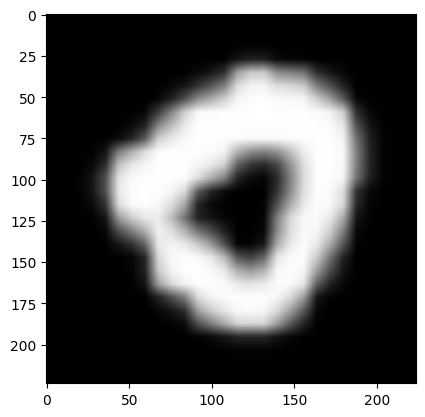

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize and convert the tensor image back to NumPy format for visualization
def imshow(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor (C, H, W) to NumPy (H, W, C)
    
    # Denormalize the image (reverse the normalization transformation)
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # Un-normalize the image
    img = np.clip(img, 0, 1)  # Clip the pixel values to [0, 1]
    
    plt.imshow(img)
    plt.show()

# Get a batch of images and labels from the dataloader
dataiter = iter(train_loader)  # Use train_loader or any other dataloader you want to visualize from
images, labels = next(dataiter)

# Visualize the first image in the batch
imshow(images[101])

In [26]:
labels[1006]

tensor(4)

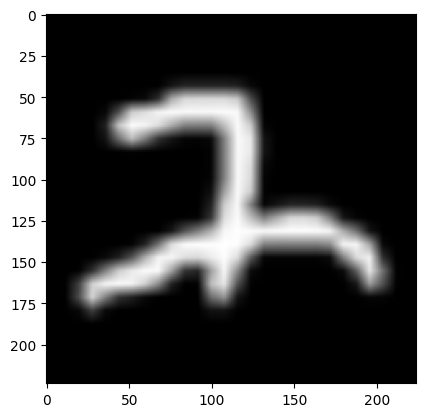

In [27]:
imshow(images[1006])

## Section